# Preparação do ambiente

## Instalação de dependências

In [1]:
# !pip install pandas
# !pip install python-dotenv
# !pip install requests
# !pip install openai==0.28.1

## Importação das bibliotecas

In [2]:
# Importação das bibliotecas
import os
import openai
from dotenv import load_dotenv
import json
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

c:\Users\aleju\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carregar variáveis de ambiente

In [3]:
load_dotenv()

True

## Configuração do OpenRouter

In [4]:
openai.api_key = os.getenv("OPENROUTER_API_KEY") # API Key do OpenRouter
openai.api_base = "https://openrouter.ai/api/v1" # URL da API do OpenRouter

In [5]:
# Modelo do OpenRouter
model_name = "meta-llama/llama-3.1-8b-instruct:free"

# Obter resposta do LLM

In [6]:
# Função para enviar uma pergunta e obter uma resposta do modelo
def get_chatbot_response(messages, system_prompt="", temperature=0, model=model_name):
    # Type check do messages
    if not isinstance(messages, list):
        raise TypeError("messages deve ser uma lista")

    # Lista de mensagens pro modelo
    input_messages = []
    for message in messages:
        # Adicionar dicionário à lista
        input_messages.append({
            "role": message["role"], # Quem está falando (usuário ou sistema)
            "content": message["content"] # Conteúdo da mensagem
        })

    response = openai.ChatCompletion.create(
        model=model, # Modelo de IA
        # Lista de mensagens
        messages=input_messages,
        # Temperatura: quantidade de aleatoriedade na resposta
        temperature=temperature, # 0 pois queremos resultados concretos
        top_p=0.8,
        max_tokens=2_000, # Limite de tokens na resposta
        # Token: unidade de medida do modelo de IA (palavras, sub-palavras, caracteres, ...)
    ).choices[0].message.content.strip()

    return response # Retornar resposta ao usuário

In [7]:
# Teste da função
msgs_usuario = [{"role": "user", "content": "Qual é a capital da Austrália?"}]
resposta = get_chatbot_response(msgs_usuario)
print(f"Usuário: {msgs_usuario[0]['content']}\nChatBot: {resposta}")

Usuário: Qual é a capital da Austrália?
ChatBot: Canberra.


# Engenharia de Prompt

## Structured output
Armazena a resposta do chatbot em um formato estruturado (como CSV ou JSON) para poder ser utilizado em outros sistemas/aplicações (como React Native).

### System Prompt
Prompt dado ao LLM que define seu comportamento.

In [8]:
system_prompt = """
Você é um assistente prestativo que responde perguntas sobre capitais de países.

Seu output deve ser um formato JSON estruturado exatamente como no exemplo abaixo. Você não tem permissão de escrever qualquer outra coisa além do objeto JSON.
[
    {
        "country": O país que o usuário perguntou a capital,
        "capital": A capital do país que o usuário perguntou,
    }
]
"""

system_prompt_message = {"role": "system", "content": system_prompt}

In [9]:
# Teste do system_prompt
messages = [
    system_prompt_message,
    {"role": "user", "content": "Qual é a capital da Nova Zelândia?"}]
resposta = get_chatbot_response(messages, system_prompt=system_prompt)
print(resposta)
print("Data type:", type(resposta))

# Converter resposta para JSON
json_resposta = json.loads(resposta)
print("\nJSON:", json_resposta)
print("Data type:", type(json_resposta))
print("Data type do objeto da lista:", type(json_resposta[0]))

# Retornar apenas a capital
print("\nCapital:", json_resposta[0]["capital"])

[
    {
        "country": "Nova Zelândia",
        "capital": "Wellington"
    }
]
Data type: <class 'str'>

JSON: [{'country': 'Nova Zelândia', 'capital': 'Wellington'}]
Data type: <class 'list'>
Data type do objeto da lista: <class 'dict'>

Capital: Wellington


In [10]:
# Teste 2
messages = [
    system_prompt_message,
    {"role": "user", "content": "Qual é a capital da França e do Brasil?"}]
resposta = json.loads(get_chatbot_response(messages, system_prompt=system_prompt))
print(resposta)
print("Data type:", type(resposta))
print("Data type do objeto da lista:", type(resposta[0]))

[{'country': 'França', 'capital': 'Paris'}, {'country': 'Brasil', 'capital': 'Brasília'}]
Data type: <class 'list'>
Data type do objeto da lista: <class 'dict'>


## Input Structuring

In [11]:
user_input = """
Obtenha para mim a capital dos seguintes países:
```
1. Itália
2. Alemanha
3. Canadá
4. Bélgica
```
"""

messages = [
    system_prompt_message,
    {"role": "user", "content": user_input}]
response = get_chatbot_response(messages)
print(json.loads(response))

[{'country': 'Itália', 'capital': 'Roma'}, {'country': 'Alemanha', 'capital': 'Berlim'}, {'country': 'Canadá', 'capital': 'Ottawa'}, {'country': 'Bélgica', 'capital': 'Bruxelas'}]


## Dê tempo ao modelo para pensar: Chain-of-thought (CoT)
Aumenta a previsão das respostas e reduz a chance de erros.

### Sem CoT:

In [12]:
# Exemplo: equação matemática
user_prompt = """
Calcule o resultado dessa equação: 259/1*8654+91072*33-12971

Seu output deve ser um JSON estruturado exatamente igual o exemplo abaixo. Você não tem permissão de escrever qualquer outra coisa além do objeto JSON (nem mesmo o passo a passo da resolução).
[{
    result: O número final resultado do cálculo da equação acima.

}]
"""
messages = [{"role": "user", "content": user_prompt}]
response = json.loads(get_chatbot_response(messages, system_prompt=system_prompt))
print(response)

{'result': 2161119}


In [13]:
resultado_real = 259/1*8654+91072*33-12971 # Resultado correto
print("Resultado correto:", resultado_real)
print("Margem de erro:", (response["result"] - resultado_real)) # Margem de erro

Resultado correto: 5233791.0
Margem de erro: -3072672.0


### Com CoT

In [14]:
# Exemplo: equação matemática com etapas
user_prompt = """
Calcule o resultado dessa equação: 259/1*8654+91072*33-12971

Seu output deve ser um JSON estruturado exatamente igual o exemplo abaixo. Você não tem permissão de escrever qualquer outra coisa além do objeto JSON:
[{
    step: Aqui, você resolve a equação aos poucos, seguindo a ordem de operações BEDMAS. Você precisa mostrar seu trabalho e calcular cada etapa que leva ao resultado final. Sinta-se à vontade para escrever em texto livre.
    result: O número final resultado do cálculo da equação acima. O número deve ser um inteiro ou float.
}]
"""
messages = [{"role": "user", "content": user_prompt}]
response = "[" + get_chatbot_response(messages, system_prompt=system_prompt) + "]"

In [15]:
print(response)

[{
  "step": "Primeiramente, vamos resolver a multiplicação de 259 e 8654: 259*8654 = 2245316",
  "result": 2245316
}]


In [16]:
print("Resultado real:", resultado_real)
print("Resultado do modelo:", response["result"])
print("Margem de erro:", (response["result"] - resultado_real)) # Margem de erro

Resultado real: 5233791.0


TypeError: string indices must be integers, not 'str'

# RAG: Retrieval Augmented Generation
Ajuda o modelo a gerar output de informações que não possui na sua memória.

>Ex: cardápio do restaurante

Essas informações devem ser injetadas no prompt para o chatbot poder responder de acordo.

In [17]:
# Teste: perguntar sobre algo não existente quando o modelo foi treinado
user_prompt = """
O que há de novo no iPhone 16?
"""
messages = [{"role": "user", "content": user_prompt}]

response = get_chatbot_response(messages)

print(response)

A Apple anunciou o iPhone 14, não o iPhone 16. O iPhone 14 foi lançado em setembro de 2022 e traz várias melhorias em relação ao seu antecessor, incluindo:

1. **Design**: O iPhone 14 tem um design renovado, com uma nova cor chamada "Starlight" e uma tela de 6,1 polegadas com uma resolução de 1170 x 2536 pixels.
2. **Processador**: O iPhone 14 é equipado com o processador A16 Bionic, que oferece uma melhoria significativa na performance e na eficiência energética.
3. **Câmera**: A câmera principal do iPhone 14 tem uma resolução de 48 MP, com uma lente ultra-grand angular e uma lente teleobjetiva. Além disso, a câmera também tem uma função de estabilização de imagem melhorada.
4. **Bateria**: A bateria do iPhone 14 é mais grande do que a do iPhone 13, o que significa que você pode usar o seu telefone por mais tempo sem precisar recarregar.
5. **Carregamento rápido**: O iPhone 14 suporta carregamento rápido de até 20W, o que é mais rápido do que o carregamento rápido de 18W do iPhone 13.

In [18]:
# Informações adicionais
iphone16 = """
The iPhone 16 introduces several exciting updates, making it one of Apple's most advanced smartphones to date. It features a larger 6.1-inch display for the base model and a 6.7-inch screen for the iPhone 16 Plus, with thinner bezels and a more durable Ceramic Shield. The iPhone 16 Pro and Pro Max boast even larger displays, measuring 6.3 and 6.9 inches respectively, offering the thinnest bezels seen on any Apple product so far.

Powered by the new A18 chip (A18 Pro for the Pro models), these phones deliver significant performance improvements, with enhanced neural engine capabilities, faster GPU for gaming, and machine learning tasks. The camera systems are also upgraded, with the base iPhone 16 sporting a dual-camera setup with a 48MP main sensor. The Pro models offer a 48MP Ultra Wide and 5x telephoto camera, enhanced by Apple’s "Camera Control" button for more flexible photography options.

Apple also introduced advanced audio features like "Audio Mix," which uses machine learning to separate background sounds from speech, allowing for more refined audio capture during video recording. Battery life has been extended, especially in the iPhone 16 Pro Max, which is claimed to have the longest-lasting battery of any iPhone 
9TO5MAC

APPLEMAGAZINE
.

Additionally, Apple has switched to USB-C for faster charging and data transfer, and the Pro models now support up to 2x faster video encoding. The starting prices remain consistent with previous generations, with the iPhone 16 starting at $799, while the Pro models start at $999.
"""

In [19]:
# Prompt incluindo informações adicionais
user_prompt = f"""
{iphone16}

O que há de novo no iPhone 16?
"""
messages = [{"role": "user", "content": user_prompt}]

response = get_chatbot_response(messages)

print(response)

O iPhone 16 apresenta várias atualizações emocionantes, tornando-o um dos smartphones mais avançados da Apple até o momento. Algumas das novidades incluem:

* Tela maior: o modelo básico tem uma tela de 6,1 polegadas e o iPhone 16 Plus tem uma tela de 6,7 polegadas, com bordos mais finos e um Shield Cerâmico mais resistente.
* Processador A18 (A18 Pro para os modelos Pro): oferece melhorias significativas de desempenho, com capacidades de motor de neurônios aprimoradas, GPU mais rápido para jogos e tarefas de aprendizado de máquina.
* Sistema de câmera atualizado: o modelo básico tem um sistema de câmera duplo com sensor principal de 48MP, enquanto os modelos Pro têm um sensor Ultra Wide de 48MP e uma câmera telefotográfica de 5x, com o botão "Camera Control" para mais opções de fotografia flexíveis.
* Áudio avançado: o recurso "Audio Mix" usa aprendizado de máquina para separar sons de fundo de fala, permitindo captura de áudio mais refinada durante gravação de vídeo.
* Bateria mais l

### Extrair automaticamente dados de contexto do banco de dados

**Embedding:** Processo de mudanças de um texto para uma matriz de números para depois fazer uma operação matemática que verifica se dois textos são semelhantes ou diferentes.

In [20]:
# Teste
samsung23 = """
The Samsung Galaxy S23 brings some incremental but notable upgrades to its predecessor, the Galaxy S22. It features the Snapdragon 8 Gen 2 processor, a powerful chip optimized for the S23 series, delivering enhanced performance, especially for gaming and multitasking. This chip ensures top-tier speed and efficiency across all models, from the base S23 to the larger S23+ and S23 Ultra​
STUFF

TECHRADAR
.

In terms of design, the S23's camera module has been streamlined by removing the raised metal contour around the cameras, creating a cleaner, sleeker look. It also sports the same 6.1-inch 120Hz AMOLED display, protected by tougher Gorilla Glass Victus 2, making it more resistant to scratches and drops​
TECHRADAR
.

The S23 Ultra stands out with its 200MP main camera, offering impressive photo clarity, especially in low-light conditions. The selfie camera across the series has been updated to a 12MP sensor, resulting in sharper selfies. The Ultra model also includes productivity tools such as the S-Pen, which remains an essential feature for note-taking and creative tasks​
STUFF

TECHRADAR
.

Battery life is solid, with the S23 Ultra featuring a 5000mAh battery that lasts comfortably through a day of heavy use. However, charging speeds still lag behind some competitors, with 45W wired charging, which is slower than other brands offering up to 125W charging​
STUFF
.

Overall, the Galaxy S23 series enhances performance, durability, and camera quality, making it a strong contender for users seeking a high-performance flagship.

"""

In [21]:
data = [iphone16, samsung23]

In [22]:
user_prompt = f"""
O que há de novo no iPhone 16?
"""

In [23]:
# Modelo de embedding
embedding_model = "BAAI/bge-small-en-v1.5"
# Carregar modelo localmente
embedding_client = SentenceTransformer(embedding_model)

In [24]:
# Função para obter os embeddings
def get_embedding(embedding_client, embedding_model, text_input):
    # Se for uma string, transforma em lista
    if isinstance(text_input, str):
        text_input = [text_input]
    
    # Gerar embeddings
    embeddings = embedding_client.encode(text_input, convert_to_numpy=True)
    # Retornar embeddings
    return embeddings

In [25]:
# Teste da função de embeddings
user_prompt_embedding = get_embedding(embedding_client, embedding_model, user_prompt)
print(user_prompt_embedding)

print("\nTamanho do vetor de embedding:", user_prompt_embedding.shape)

[[-4.83366027e-02  2.14187801e-02  4.58678864e-02 -1.13048293e-02
  -2.79313605e-02 -4.58465219e-02  2.00635642e-02  4.64338437e-02
  -3.04769035e-02  5.64293144e-03  5.10987863e-02 -2.05539465e-02
  -2.60537472e-02 -2.04901434e-02  8.54229331e-02  5.00899889e-02
   8.67976621e-02 -7.68268779e-02 -3.72335687e-02  1.24540897e-02
  -1.71125401e-02 -4.44358736e-02 -4.59065586e-02 -3.50812711e-02
   9.41397157e-03  4.60619256e-02 -1.12431562e-02  1.29006933e-02
  -1.32150454e-02 -1.35516062e-01 -1.03941374e-02  2.65004802e-02
   3.47601436e-02  5.81780709e-02  2.37790477e-02 -3.54762934e-02
  -1.84392221e-02  3.04669105e-02  3.22139263e-02  9.09115896e-02
   2.43219435e-02  2.17773803e-02 -9.95147452e-02 -1.97999105e-02
   3.97775881e-02  1.18633471e-02  2.65844073e-02  5.15497662e-02
   8.52345396e-03  1.38412905e-03  1.46200936e-02  6.23488910e-02
  -4.11889935e-03 -3.58895883e-02  2.61343792e-02  5.10657541e-02
   5.18704718e-03 -1.61395613e-02  4.15528715e-02  3.89984734e-02
   9.23724

In [26]:
# Obter embeddings para os dados
data_embeddings = [get_embedding(embedding_client, model_name, text)[0] for text in data]
print(data_embeddings)

[array([-6.68698847e-02,  3.26296426e-02,  4.09968756e-02, -2.52709002e-03,
       -3.83168049e-02,  1.11468183e-02,  2.93546580e-02,  1.77761279e-02,
        4.18668576e-02,  5.58414720e-02,  8.22484270e-02, -1.35688193e-03,
       -6.02875613e-02,  3.89838126e-03,  4.12556492e-02,  6.07227609e-02,
        1.34707943e-01, -1.73485070e-01, -4.75846455e-02,  5.06558595e-03,
        3.75499241e-02, -4.50500287e-02, -1.01545285e-02, -2.11867318e-02,
        3.87785397e-02,  4.21463996e-02, -1.01517942e-02, -1.06640011e-02,
        1.29632521e-02, -1.82909235e-01,  1.38680777e-02,  1.24545852e-02,
        4.87405062e-02,  1.04251783e-02, -5.52052334e-02,  1.65027066e-03,
       -3.36267762e-02, -1.09609971e-02,  3.51494588e-02,  4.75456789e-02,
       -1.64484500e-03,  6.14748709e-02, -3.81678939e-02,  1.01085305e-02,
        1.45128658e-02,  3.46328393e-02,  1.67133491e-02, -6.12372532e-02,
       -1.10574830e-02, -1.06300684e-02,  4.30383198e-02, -2.49003861e-02,
        3.81095055e-03, 

Medir similaridade entre os dados do embedding e os dados do usuário:

In [27]:
# Qual embedding (iPhone 16 ou Samsung 23) é mais próximo do prompt do usuário?
data_similarity = cosine_similarity(user_prompt_embedding, data_embeddings)

print(data_similarity) # Resultado
print(f"\tiPhone 16: {data_similarity[0][0]}\n\tSamsung 23: {data_similarity[0][1]}")

[[0.654349  0.4679091]]
	iPhone 16: 0.6543490290641785
	Samsung 23: 0.4679090976715088


In [28]:
# Verificar dado mais similar
closest_entry_index = data_similarity.argmax() # Obtêm o índice do dado mais similar

print("Índice do dado mais similar no vetor:", closest_entry_index)
print(data[closest_entry_index])

Índice do dado mais similar no vetor: 0

The iPhone 16 introduces several exciting updates, making it one of Apple's most advanced smartphones to date. It features a larger 6.1-inch display for the base model and a 6.7-inch screen for the iPhone 16 Plus, with thinner bezels and a more durable Ceramic Shield. The iPhone 16 Pro and Pro Max boast even larger displays, measuring 6.3 and 6.9 inches respectively, offering the thinnest bezels seen on any Apple product so far.

Powered by the new A18 chip (A18 Pro for the Pro models), these phones deliver significant performance improvements, with enhanced neural engine capabilities, faster GPU for gaming, and machine learning tasks. The camera systems are also upgraded, with the base iPhone 16 sporting a dual-camera setup with a 48MP main sensor. The Pro models offer a 48MP Ultra Wide and 5x telephoto camera, enhanced by Apple’s "Camera Control" button for more flexible photography options.

Apple also introduced advanced audio features like 

In [29]:
# Criar prompt com os dados mais similares com a pergunta original do usuário
user_prompt_with_data = f"""
{data[closest_entry_index]}

{user_prompt}
"""

print(user_prompt_with_data)



The iPhone 16 introduces several exciting updates, making it one of Apple's most advanced smartphones to date. It features a larger 6.1-inch display for the base model and a 6.7-inch screen for the iPhone 16 Plus, with thinner bezels and a more durable Ceramic Shield. The iPhone 16 Pro and Pro Max boast even larger displays, measuring 6.3 and 6.9 inches respectively, offering the thinnest bezels seen on any Apple product so far.

Powered by the new A18 chip (A18 Pro for the Pro models), these phones deliver significant performance improvements, with enhanced neural engine capabilities, faster GPU for gaming, and machine learning tasks. The camera systems are also upgraded, with the base iPhone 16 sporting a dual-camera setup with a 48MP main sensor. The Pro models offer a 48MP Ultra Wide and 5x telephoto camera, enhanced by Apple’s "Camera Control" button for more flexible photography options.

Apple also introduced advanced audio features like "Audio Mix," which uses machine learnin

In [30]:
# Enviar prompt pro modelo e obter a resposta
messages = [{"role": "user", "content": user_prompt_with_data}]
response = get_chatbot_response(messages)
print(response)

O iPhone 16 apresenta várias atualizações emocionantes, tornando-o um dos smartphones mais avançados da Apple até o momento. Algumas das novidades incluem:

* Tela maior: o modelo básico tem uma tela de 6,1 polegadas e o iPhone 16 Plus tem uma tela de 6,7 polegadas, com bordos mais finos e um Shield Cerâmico mais resistente.
* Processador A18 (A18 Pro para os modelos Pro): oferece melhorias significativas de desempenho, incluindo capacidades de motor de neurônios aprimoradas, GPU mais rápido para jogos e tarefas de aprendizado de máquina.
* Sistema de câmera atualizado: o modelo básico tem um conjunto de câmera dupla com sensor principal de 48 MP, enquanto os modelos Pro oferecem uma câmera Ultra Wide de 48 MP e uma câmera telefotográfica de 5x, com o botão "Camera Control" para mais opções de fotografia flexíveis.
* Áudio avançado: a "Audio Mix" usa aprendizado de máquina para separar sons de fundo da fala, permitindo captura de áudio mais refinada durante a gravação de vídeo.
* Bater

## Confiança
A confiança mede a probabilidade de um cliente que comprou um determinado item ou conjunto de itens (antecedente) também comprar outro item ou conjunto de itens (consequente). Uma forma de quantificar a força de uma regra de associação.
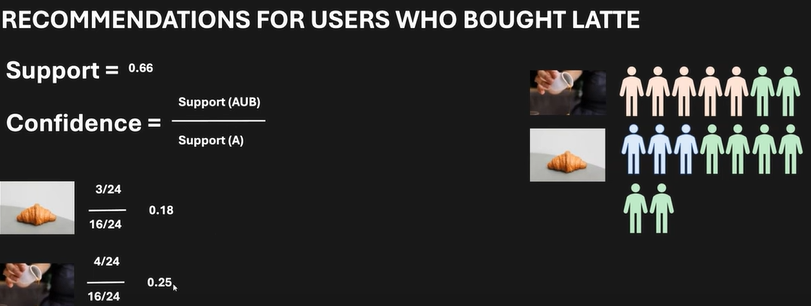

**Lift:** a probabilidade de dois itens (ou conjuntos de itens) serem comprados juntos em comparação a se fossem comprados aleatoriamente e independentemente.
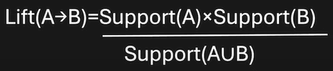
- **Lift > 1 (Associação positiva):** os itens são comprados juntos com mais frequência do que por acaso.
- **Lift = 1 (Sem associação):** os itens são comprados juntos sempre que esperado por acaso.
- **Lift < 1 (Associação negativa):** os itens são comprados juntos com menos frequência do que por acaso.